In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import *
from pandas import DataFrame, Series

plt.style.use('seaborn')
sns.set(font_scale=2.5) 

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#캐글사이트(https://www.kaggle.com/c/titanic/data)에서 데이터 파일을 다운로드 받은 경로에 맞게 설정하여 데이터 로드.
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
#학습데이터, 테스트데이터의 차원 조회 (테스트데이터에는 'survived' 칼럼이 없음)
df_train.shape, df_test.shape

((891, 12), (418, 11))

In [4]:
columns=df_train.columns
columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
df_test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [7]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
df_train['Survived'].value_counts() #target value로 사용할 컬럼인 'Survived'의 클래스 별 데이터 수

0    549
1    342
Name: Survived, dtype: int64

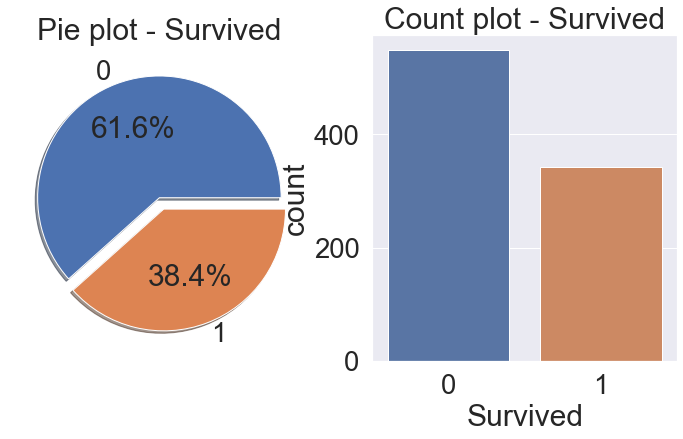

In [9]:
#'Survived' 컬럼 시각화
f, ax = plt.subplots(1, 2, figsize =(12, 6))
df_train["Survived"].value_counts().plot.pie(explode=[0,0.1], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Pie plot - Survived")
ax[0].set_ylabel('')
sns.countplot("Survived", data=df_train, ax=ax[1])
ax[1].set_title("Count plot - Survived")

plt.show()

In [10]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
#이번 실습에서 학습에 사용하지 않을 컬럼 제거
train = df_train.drop(['Cabin', 'Embarked', 'Name', 'Ticket', 'PassengerId'],axis=1)
test = df_test.drop(['Cabin', 'Embarked', 'Name', 'Ticket'],axis=1)

#결측치를 평균값으로 대체
train["Age"].fillna(train.groupby("Sex")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Sex")["Age"].transform("mean"), inplace=True)
test["Fare"].fillna(test.groupby("Sex")["Fare"].transform("median"), inplace=True)

In [13]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [14]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [15]:
#문자열로 이루어진 'sex' 컬럼은 숫자로 매핑
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

#'Age', 'Fare' 컬럼에 대하여 평균으로부터 3시그마 안에 포함되지 않는 값들은 이상치로 판단하여 모두 제거
age_mean = train['Age'].mean()
age_std = train['Age'].std()
indexNames = train[train['Age'] < age_mean - 3*age_std].index
train.drop(indexNames , inplace=True)
indexNames = train[train['Age'] > age_mean + 3*age_std].index
train.drop(indexNames , inplace=True)
fare_mean = train['Fare'].mean()
fare_std = train['Fare'].std()
indexNames = train[train['Fare'] < fare_mean - 3*fare_std].index
train.drop(indexNames , inplace=True)
indexNames = train[train['Fare'] > fare_mean + 3*fare_std].index
train.drop(indexNames , inplace=True)